<a href="https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/play_for_beginners/dinov3_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dinov3 Demo
*Last modified 2 September 2025*   
Use MetaAI's latest computer vision model, Dinov3, a self-supervised foundation model that was released in August 2025. Identify features in any image, convert them to segmentations using dimensionality reduction and clustering, then convert segmentations into bounding boxes.

First, you need to request download permissions from [MetaAI](https://ai.meta.com/resources/models-and-libraries/dinov3-downloads/). See documentation on [HuggingFace](https://huggingface.co/docs/transformers/main/en/model_doc/dinov3) and [GitHub](https://github.com/facebookresearch/dinov3?ref=aiartweekly). Built with DINOv3 and [licensed under MetaAI](https://ai.meta.com/resources/models-and-libraries/dinov3-license/?fbclid=IwZXh0bgNhZW0CMTAAYnJpZBExZ21RaE10TjdKQlRERk5lVAEee_PwlnA3G9XMBzWrtH7faFT1TZ-jcxbQgfwcdBEuwq6wdU4EbYUvq_Xe_-c_aem_eCv4c_bxKZvdRGPCeQAfMw).

In [1]:
#@title Clone Dinov3 repo
!git clone https://github.com/facebookresearch/dinov3
%cd dinov3
!pip install -e .

# Download Dinov3 trained model and license - ViT-S/16 distilled
!pip3 install --upgrade gdown
!gdown  1H54yGgELGJQH8JLr8hemwu6-LKN2iwjG

# Move downloaded zipped files to checkpoints dir and remove empty dirs resulting from zipping
!mkdir '/content/dinov3/checkpoints'
!unzip '/content/dinov3/dinov3.zip' -d '/content/dinov3/checkpoints'
!mv '/content/dinov3/checkpoints/content/drive/MyDrive/cv_demos/dinov3/dinov3_vits16_pretrain_lvd16.pth' '/content/dinov3/checkpoints/'
!mv '/content/dinov3/checkpoints/content/drive/MyDrive/cv_demos/dinov3/metaai_dinov3_license.txt' '/content/dinov3/checkpoints/'
!rm -r '/content/dinov3/checkpoints/content'

Cloning into 'dinov3'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 329 (delta 64), reused 24 (delta 24), pack-reused 220 (from 2)
Receiving objects: 100% (329/329), 9.82 MiB | 18.72 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/content/dinov3
Obtaining file:///content/dinov3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.9 MB/s eta 0:00:00
  Building editable for dinov3 (pyproject.toml) ... done
  Created wheel for dinov3: filename=dinov3-0.0.1-0.editable-py3-none-any.whl size=13307 sha256=3956260d480

In [2]:
#@title Load model
import torch
from PIL import Image
from torchvision import transforms
import requests
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize
import dinov3
from dinov3.models import vision_transformer as vits
from dinov3.models.vision_transformer import vit_small
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from transformers.image_utils import load_image
import cv2

# Replace with your actual URL or path
weights_path = "checkpoints/dinov3_vits16_pretrain_lvd16.pth" # @param ["checkpoints/dinov3_vits16_pretrain_lvd16.pth"] {"allow-input":true}

# Load DINOv3 ViT-S/16
model = vit_small(patch_size=16)
checkpoint = torch.load(weights_path, map_location="cpu")
model.load_state_dict(checkpoint, strict=False)
model.eval()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps

Features shape: torch.Size([1, 196, 384])


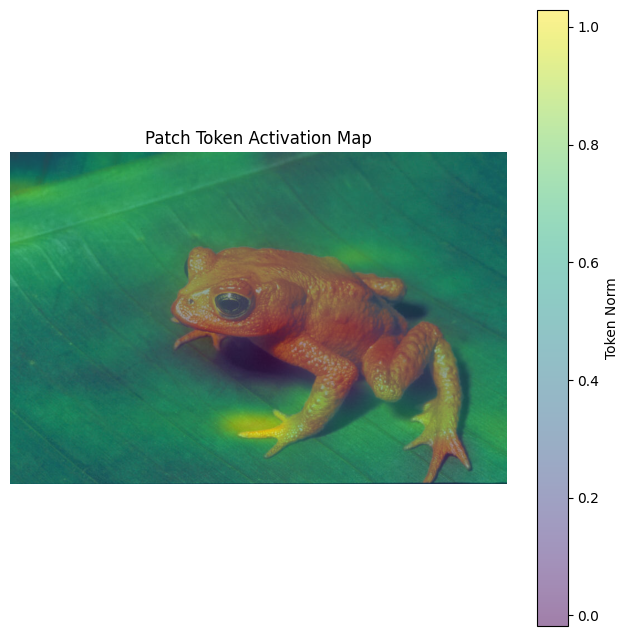

In [12]:
#@title Run inference

# Load image from URL
IMAGE_URL = "https://content.eol.org/data/media/be/31/2b/30.444319cfd1f13c82dee7fb19c240975f.jpg" # @param ["https://content.eol.org/data/media/85/2b/a1/7.CalPhotos_0000_0000_0211_1804.jpg"] {"allow-input":true}
img = load_image(IMAGE_URL)

# Pre-process/transform image to be fed into model
# Modified from: https://github.com/facebookresearch/dinov3?ref=aiartweekly
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = transform(img).unsqueeze(0)

# Run inference
with torch.no_grad():
    features = model.get_intermediate_layers(img_tensor, n=len(model.blocks))[-1]
print("Features shape:", features.shape)

# Compute activation strengths (L2 norm of patch features)
activation = features.norm(dim=-1)

# Reshape to 14x14 grid
activation_map = activation[0].reshape(14, 14).cpu().numpy()

# Normalize to [0, 1]
activation_map -= activation_map.min()
activation_map /= activation_map.max()

# Resize to match image size (224x224)
activation_map_resized = resize(
    torch.tensor(activation_map).unsqueeze(0).unsqueeze(0),
    size=(img.height, img.width),  # (H, W)
    interpolation=transforms.InterpolationMode.BICUBIC,
    antialias=True
).squeeze().numpy()

# Overlay heatmap on image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(activation_map_resized, cmap='viridis', alpha=0.5)
plt.axis("off")
plt.title("Activation Saliency Map")
plt.colorbar(label="Activation")
plt.show()

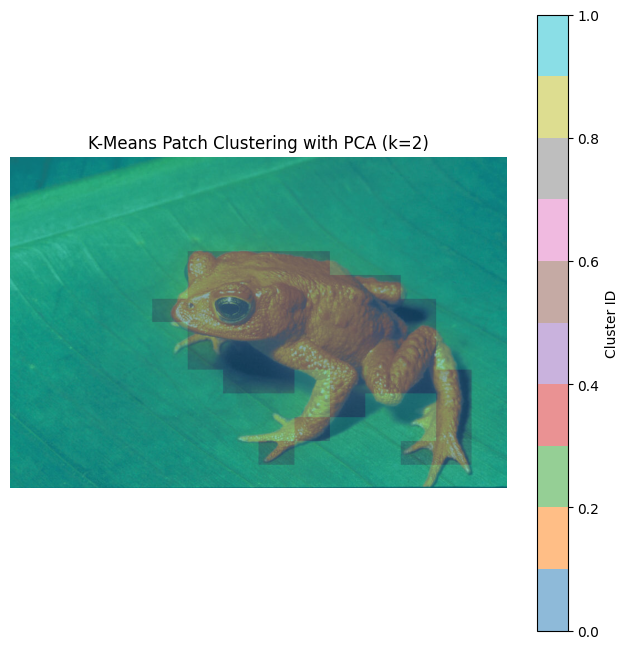

In [13]:
#@title Cluster into segmentation for k=n segments

# Extract patch tokens
patch_tokens = features.cpu().numpy().squeeze()

# Reduce dimensionality with PCA
pca = PCA(n_components=20, random_state=42)
patch_tokens_reduced = pca.fit_transform(patch_tokens)

# K-means clustering on PCA-reduced features
k = 2 #@param
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(patch_tokens_reduced)

# Reshape labels into 14x14 grid
segmentation_map = labels.reshape(14, 14)

# Upsample to image size (224x224)
seg_tensor = torch.tensor(segmentation_map).unsqueeze(0).unsqueeze(0).float()
seg_upsampled = resize(
    seg_tensor,
    size=(img.height, img.width),
    interpolation=transforms.InterpolationMode.NEAREST
).squeeze().numpy()

# Visualize clusters
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(seg_upsampled, cmap='tab10', alpha=0.5)
plt.axis('off')
plt.title(f"K-Means Patch Clustering with PCA (k={k})")
plt.colorbar(label="Cluster ID")
plt.show()


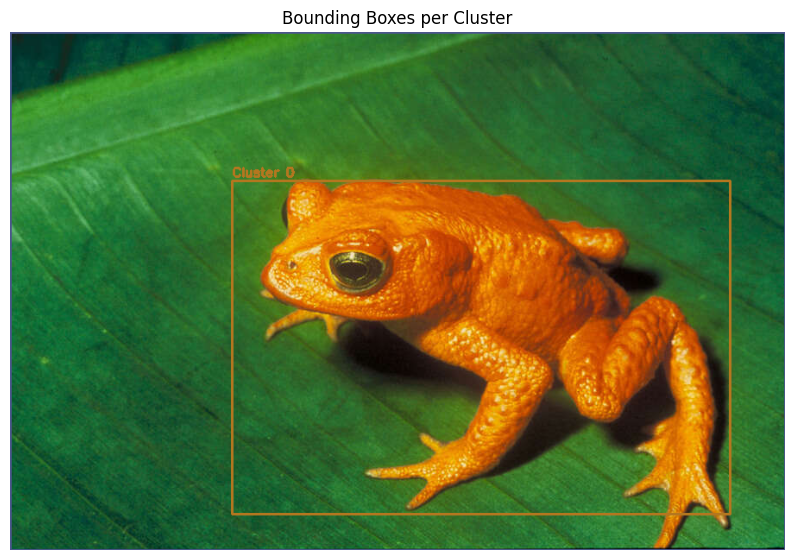

In [14]:
#@title Convert segmentation into bounding box

# Upsample the segmentation map (224x224)
seg_upsampled_uint8 = seg_upsampled.astype(np.uint8)

# Convert clusters to boxes
boxes = []
for cluster_id in range(k):
    # Create binary mask for current cluster
    mask = (seg_upsampled_uint8 == cluster_id).astype(np.uint8) * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract bounding boxes from contours
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        boxes.append((x, y, w, h, cluster_id))

# Visualize bounding boxes on image
img_np = np.array(img)
# Draw boxes based on class colors
for (x, y, w, h, cid) in boxes:
    color = plt.cm.tab10(cid / k)[:3]
    color_bgr = tuple(int(c*255) for c in color[::-1])
    cv2.rectangle(img_np, (x, y), (x+w, y+h), color_bgr, 2)
    cv2.putText(img_np, f"Cluster {cid}", (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_np)
plt.axis('off')
plt.title("Bounding Boxes per Cluster")
plt.show()